Si el sistema fuera un resorte con un objeto adherido, la expresión describe cómo la posición del objeto oscila en el tiempo mientras pierde energía debido al amortiguamiento (como la fricción o resistencia del aire).

**Oscilador armónicoo**




**1. Problema físico: oscilador subamortiguado**

El sistema que se modela es un oscilador armónico amortiguado descrito por la ecuación diferencial:

$$
\frac{d^2 x}{d t^2}+\xi \frac{d x}{d t}+\omega_0^2 x=0
$$


Donde:
- $x(t)$ es la posición del oscilador en función del tiempo.
- $\quad \xi$ es el coeficiente de amortiguamiento.
- $\quad \omega_0$ es la frecuencia angular natural del sistema.

Condiciones iniciales:

$$
x(0)=x_0, \quad \frac{d x}{d t}(0)=0
$$


La solución exacta para el caso subamortiguado $\left(\xi<2 \omega_0\right)$ es:

$$
x(t)=x_0 e^{-\frac{t}{2} t} \cos (\omega t)
$$

donde $\omega=\sqrt{\omega_0^2-\frac{\xi^2}{4}}$.
El objetivo es resolver esta ecuación diferencial mediante el método de redes neuronales propuesto por Lagaris et al., comparando la solución numérica con la solución analítica.

Para nuestro problema consideramos los siguientes parámetros.

- $x_0=1$ : posición inicial.
- $\omega_0=4 \pi$ : frecuencia angular natural.
- $\xi=2.0$ : coeficiente de amortiguamiento.



**2. Arquitectura de la red neuronal**

La red neuronal se entrena para aproximar la solución de la ecuación diferencial:
- Entrada: tiempo $t$.
- Salidas: posición $x(t)$.
- Estructura: 3 capas ocultas con activación GELU, con 128, 256, y 128 neuronas, respectivamente.

Condiciones iniciales: Se incorporan en la solución propuesta $x_t(t, N)=x_0+N(t) \cdot t^2$, asegurando que $x(0)=x_0$.

**3. Entrenamiento**
- Función de pérdida:
Pérdida = Residuo de la EDO + 0.1 • Error analítico.

Donde el residuo evalúa si la red neuronal cumple con la ecuación diferencial.
- Optimización:
- Optimizador Adam con tasa de aprendizaje inicial $l r=0.01$.
- Scheduler para ajustar dinámicamente lr basado en la pérdida.

**4. Resultados**
1. Comparación de soluciones: La red neuronal se ajusta muy bien a la solución analítica exacta.
2. Curva de pérdida: Muestra una convergencia efectiva durante el entrenamiento.
3. Error absoluto: Los errores son pequeños y se mantienen dentro de una desviación estándar baja.

**Código explicado linea por linea**

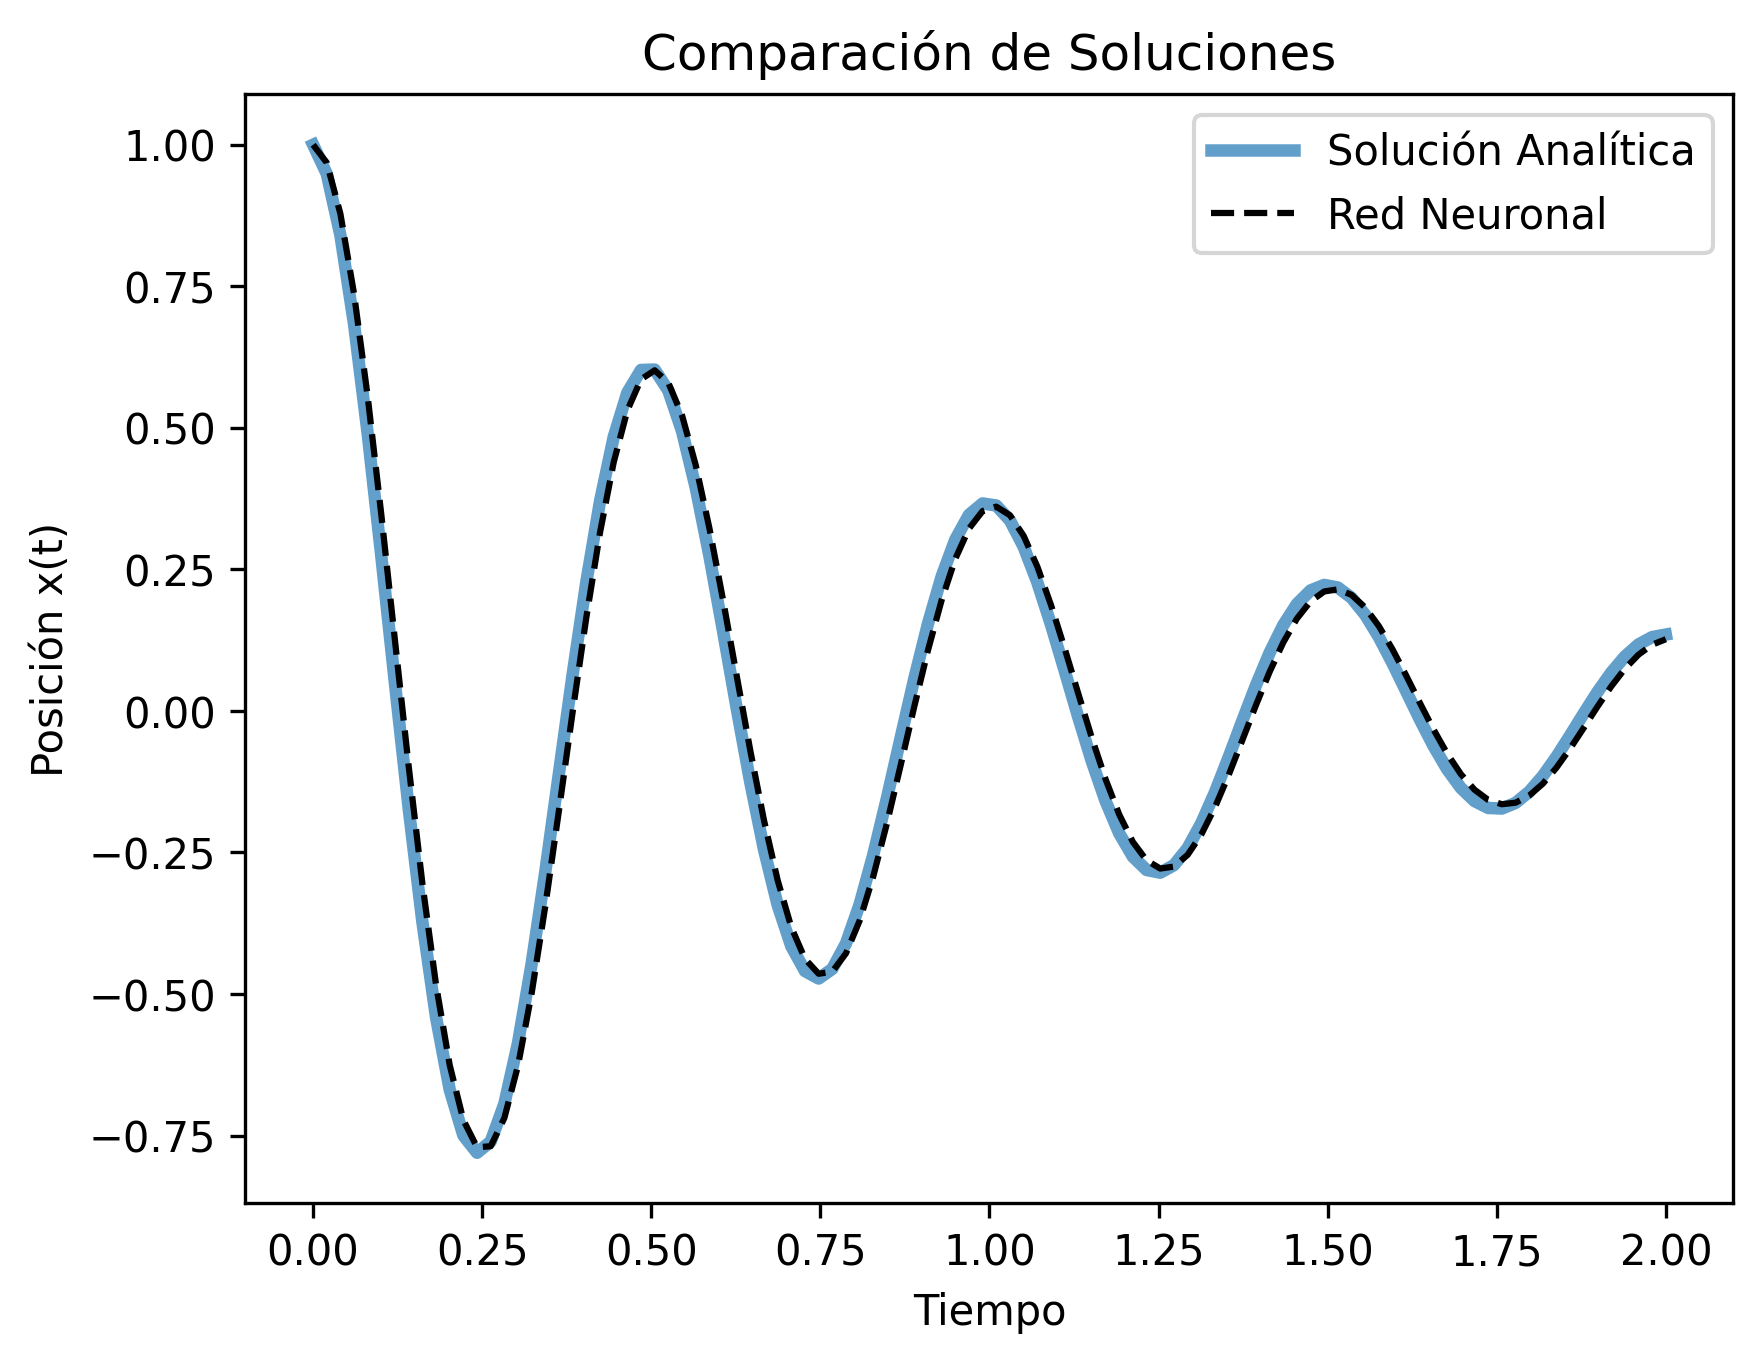

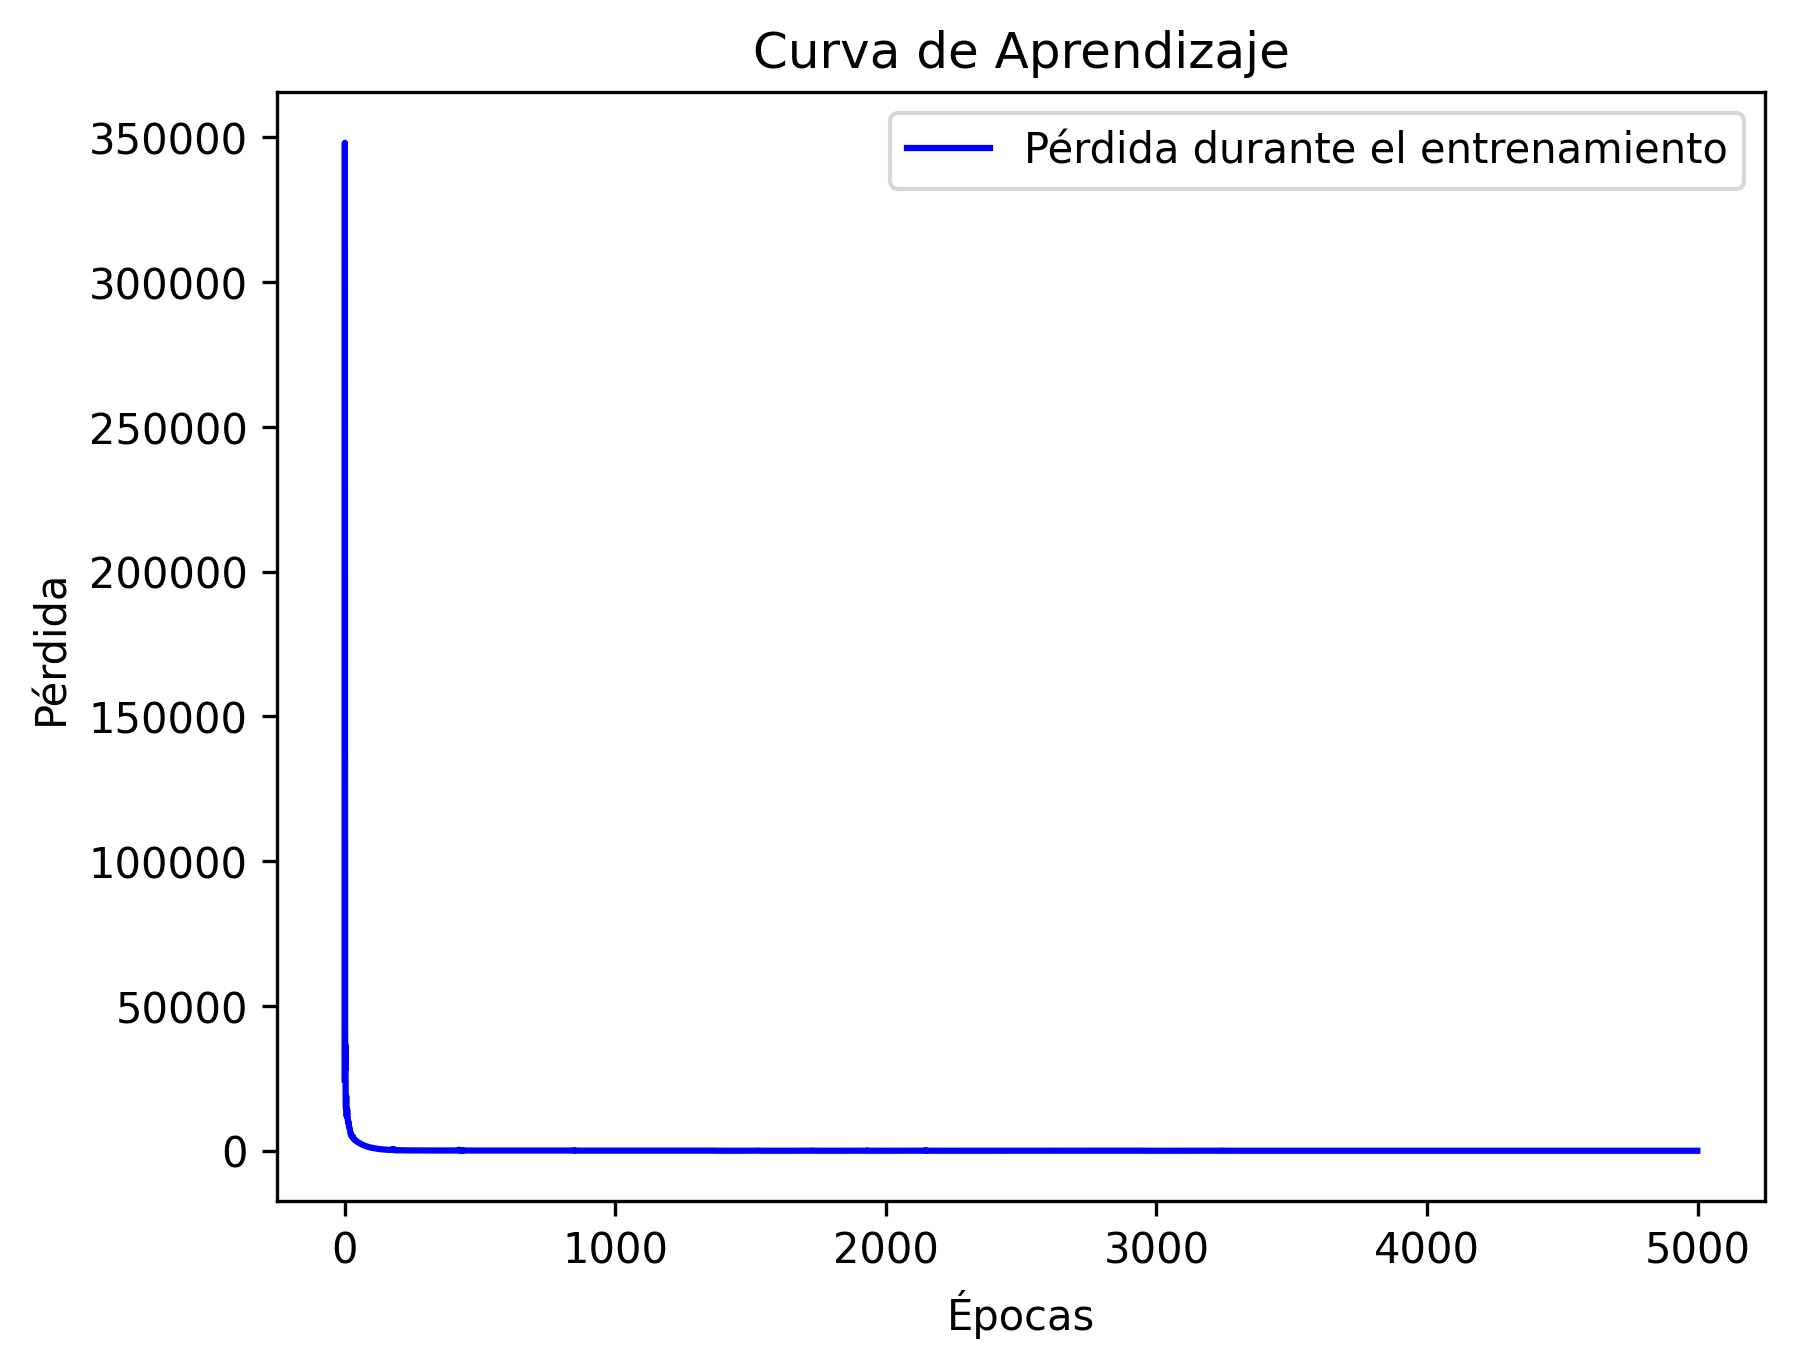

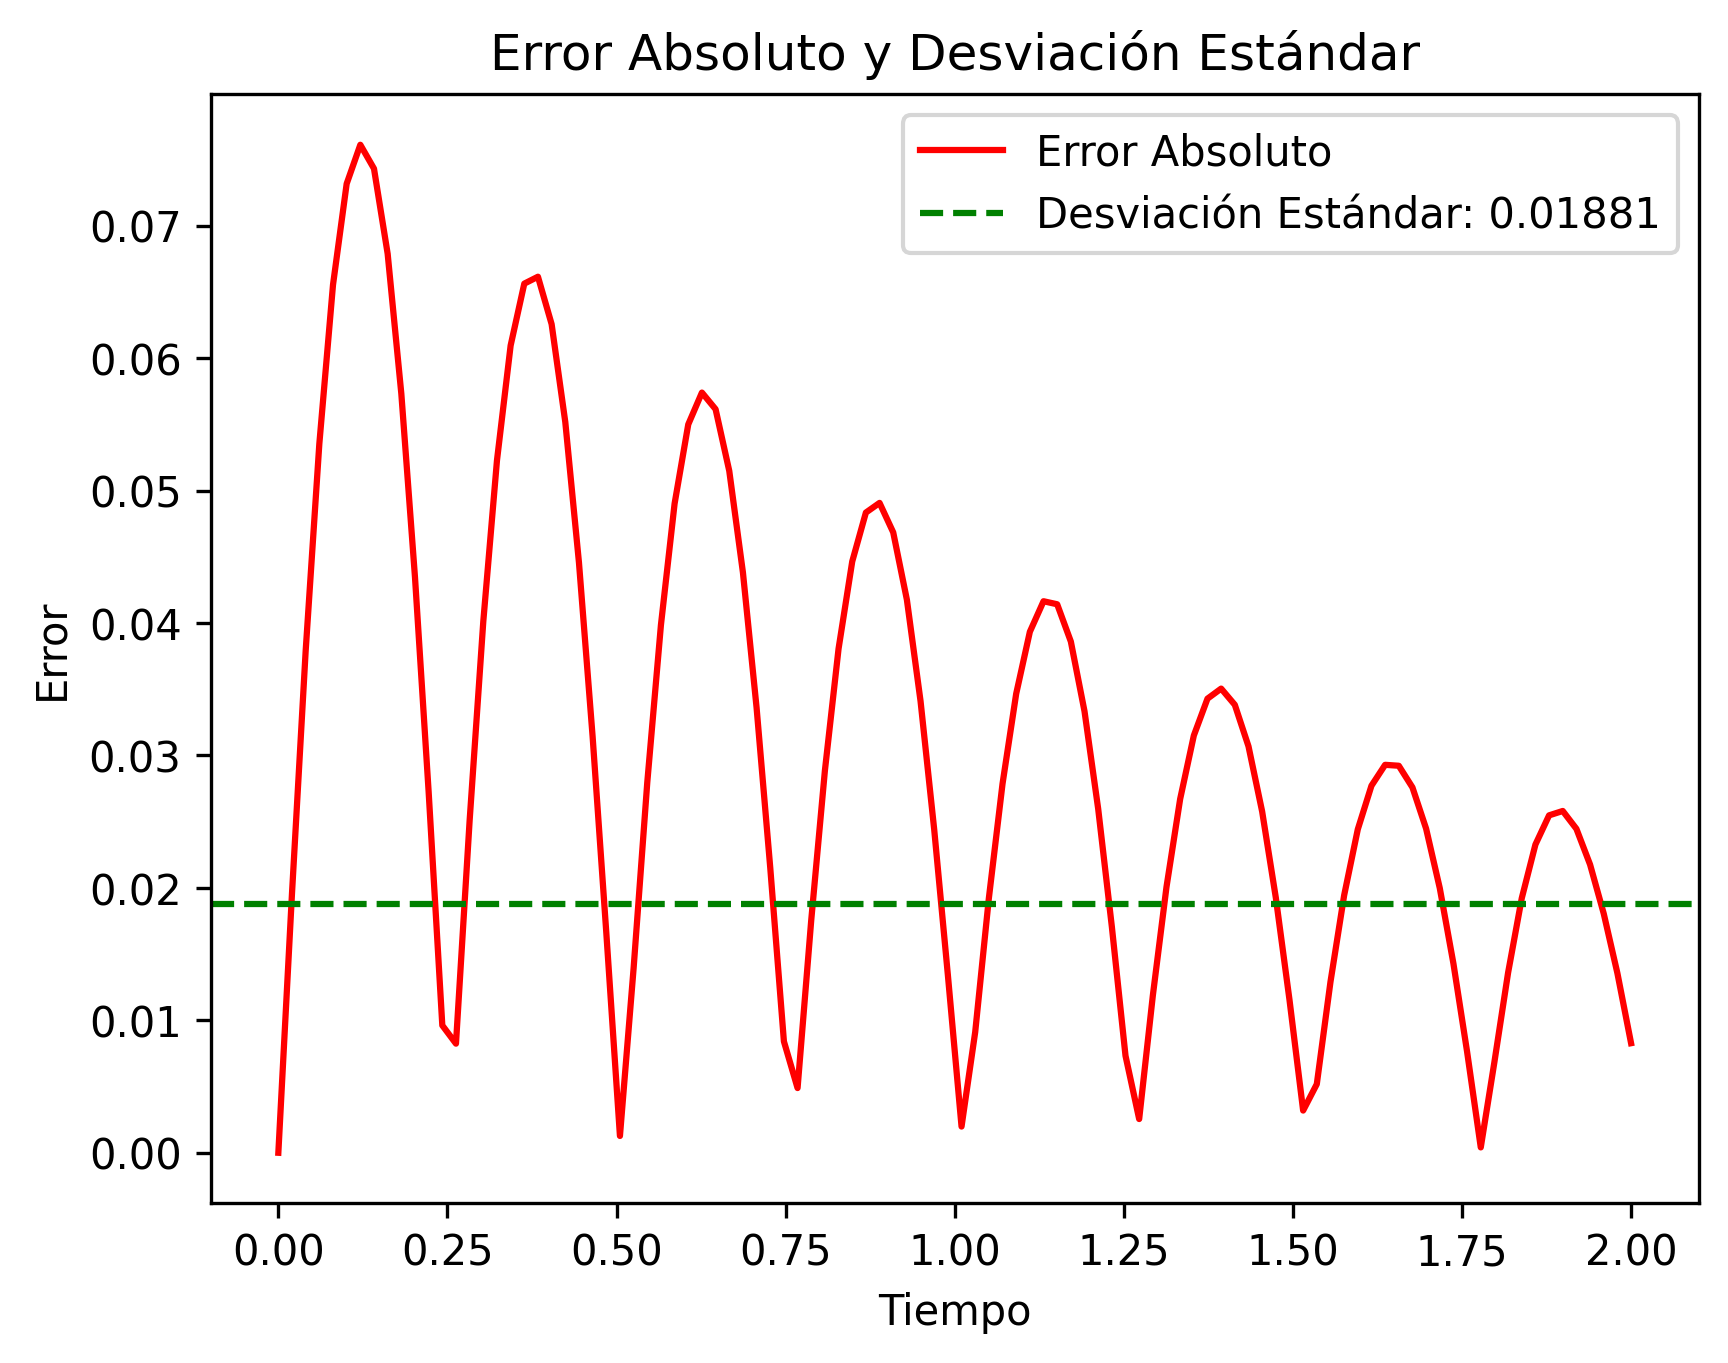

In [ ]:
# Importamos las bibliotecas necesarias
import torch  # Biblioteca para cálculo tensorial y redes neuronales
import torch.nn as nn  # Submódulo de PyTorch que contiene clases para construir y entrenar redes neuronales (capas, activaciones, etc.).
import matplotlib.pyplot as plt  # Para visualización de gráficos
import numpy as np  # Operaciones numéricas
from math import pi  # Para constantes matemáticas como π

torch.manual_seed(42)  # Establece una semilla para los generadores de números aleatorios de PyTorch, asegurando la reproducibilidad de los resultados. Propósito: Asegura que los resultados sean reproducibles, ya que el entrenamiento y la inicialización de los pesos dependen de números aleatorios.


# Parámetros del problema físico
x0 = 1.0  # Condición inicial: posición inicial del oscilador
w0 = 4 * pi  # Frecuencia angular natural
xi = 2.0  # Coeficiente de amortiguamiento


# Frecuencia angular modificada para el caso subamortiguado
w = torch.sqrt(torch.tensor(w0**2 - xi**2 / 4))


# Solución analítica exacta para el caso subamortiguado
x_sol_under = lambda t: x0 * torch.exp(-0.5 * xi * t) * torch.cos(w * t)

# En esta línea, lambda t significa que la función toma un único parámetro t (el tiempo) y devuelve el valor calculado por la expresión después de los dos puntos.
# El uso de lambda permite definir una función simple y concisa para calcular la solución analítica, sin necesidad de crear una función completa con def.
# Es útil porque la función x_sol_under solo tiene una línea de código y se utilizará más adelante para comparar la solución obtenida por la red neuronal con la solución analítica.


# Definimos la arquitectura de la red neuronal
class OscillatorNN(nn.Module):
    """
    Arquitectura de una red neuronal para resolver el problema del oscilador amortiguado.
    """
    def __init__(self):
        super().__init__()
        # La red tiene tres capas ocultas y una capa de salida
        self.net = nn.Sequential(
            nn.Linear(1, 128),  # Capa 1: Entrada -> 128 neuronas
            nn.GELU(),  # Activación GELU: suave y eficiente
            nn.Linear(128, 256),  # Capa 2: 128 -> 256 neuronas
            nn.GELU(),  # Activación GELU
            nn.Linear(256, 128),  # Capa 3: 256 -> 128 neuronas
            nn.GELU(),  # Activación GELU
            nn.Linear(128, 1, bias=False)  # Capa de salida: 128 -> 1 neurona
        )

    def forward(self, t):
        return self.net(t)


# Instancia de la red neuronal
N = OscillatorNN()


# Solución aproximada garantizando las condiciones iniciales
x_t = lambda t, N: x0 + N(t) * (t**2)
# En este caso, lambda t, N define una función que toma dos parámetros: t (el tiempo) y N (el modelo de la red neuronal). La función devuelve una expresión que depende de ambos parámetros.


# Función de pérdida: incluye la ecuación diferencial y comparación con la solución analítica
def loss(t, N):
    t.requires_grad = True  # Permite calcular derivadas respecto a t
    x = x_t(t, N)  # Solución aproximada
    dxdt = torch.autograd.grad(x, t, torch.ones_like(t), create_graph=True)[0]  # Primera derivada
    d2xdt2 = torch.autograd.grad(dxdt, t, torch.ones_like(t), create_graph=True)[0]  # Segunda derivada
    loss_ode = d2xdt2 + xi * dxdt + (w**2) * x  # Residuo de la ecuación diferencial
    error_analytical = torch.mean((x - x_sol_under(t))**2)  # Diferencia con la solución analítica
    return torch.mean(loss_ode**2) + 0.1 * error_analytical  # Combinación ponderada de ambas pérdidas
# se observa como se incrementa el error.

# Optimizador y scheduler para ajuste dinámico de la tasa de aprendizaje
optimizer = torch.optim.Adam(N.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.5)

# Entrenamiento
t_train = torch.linspace(0, 2, 500).reshape(-1, 1)  # Puntos de entrenamiento
loss_history = []  # Para guardar la evolución de la pérdida

for epoch in range(5000):  # Hasta 5000 iteraciones
    optimizer.zero_grad()  # Reinicia gradientes
    l = loss(t_train, N)  # Calcula la pérdida
    l.backward()  # Calcula los gradientes
    optimizer.step()  # Actualiza los parámetros
    scheduler.step(l)  # Ajusta la tasa de aprendizaje
    loss_history.append(l.item())  # Guarda el valor de la pérdida
    if l.item() < 1e-5:  # Condición de parada
        break

# Evaluación
t_eval = torch.linspace(0, 2, 100).reshape(-1, 1)  # Puntos de evaluación
with torch.no_grad():
    nn_solution = x_t(t_eval, N).numpy()  # Solución de la red neuronal
analytical_solution = x_sol_under(t_eval).numpy()  # Solución analítica exacta

# Gráficas
# 1. Solución analítica vs red neuronal
plt.figure(dpi=300)
plt.plot(t_eval, analytical_solution, label="Solución Analítica", linewidth=3, alpha=0.7)
plt.plot(t_eval, nn_solution, "--", label="Red Neuronal", color="k")
plt.xlabel("Tiempo")
plt.ylabel("Posición x(t)")
plt.title("Comparación de Soluciones")
plt.legend()
plt.show()

# 2. Curva de pérdida
plt.figure(dpi=300)
plt.plot(loss_history, label="Pérdida durante el entrenamiento", color="b")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.title("Curva de Aprendizaje")
plt.legend()
plt.show()

# 3. Error absoluto
error = np.abs(nn_solution - analytical_solution)
plt.figure(dpi=300)
plt.plot(t_eval, error, label="Error Absoluto", color="r")
plt.axhline(np.std(error), color="g", linestyle="--", label=f"Desviación Estándar: {np.std(error):.5f}")
plt.xlabel("Tiempo")
plt.ylabel("Error")
plt.title("Error Absoluto y Desviación Estándar")
plt.legend()
plt.show()


Ventajas del Método de Lagaris
1. No requiere discretización explícita: Se aproxima la solución como una función continua, evitando problemas de inestabilidad numérica.
2. Condiciones de frontera integradas: Se garantizan automáticamente a través de la formulación de la solución aproximada $x_t(t, N)$.
3. Aplicable a sistemas complejos: Adecuado para ecuaciones diferenciales ordinarias y parciales.

Desventajas del Método de Lagaris
1. Dependencia de la capacidad de la red: La precisión depende de la arquitectura de la red neuronal.
2. Alto costo computacional: Entrenar redes neuronales puede ser más lento que métodos numéricos tradicionales.
3. Difícil de ajustar: Requiere cuidado al diseñar la función de pérdida y al ajustar hiperparámetros.

Referencias
1. Lagaris, I. E., Likas, A., \& Fotiadis, D. I. (1998). Artificial neural networks for solving ordinary and partial differential equations. IEEE Transactions on Neural Networks.
2. Goodfellow, I., Bengio, Y., \& Courville, A. (2016). Deep Learning. MIT Press.
3. Raissi, M., Perdikaris, P., \& Karniadakis, G. E. (2019). Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations. Journal of Computational Physics.


# **Descripción detallada de todos los procesos del código.**

**Seed**

La línea `torch.manual_seed(42)` en PyTorch se utiliza para establecer una semilla aleatoria que controla la generación de números pseudoaleatorios dentro de PyTorch. Esto incluye operaciones como inicialización de pesos, generación de tensores aleatorios, divisiones de datos, entre otras.

Propósito:
Establecer una semilla permite reproducir experimentos, ya que asegura que cada vez que se ejecute el código, los números aleatorios generados sean los mismos.

¿Cómo funciona?
PyTorch utiliza un generador de números pseudoaleatorios (PRNG, por sus siglas en inglés).
Cuando se establece una semilla con torch.manual_seed(seed), este PRNG se inicializa con el valor seed (en este caso, 42).
A partir de esa semilla, los números aleatorios generados seguirán un patrón predecible.

In [ ]:
import torch

# Establecer la semilla
torch.manual_seed(42)

# Generar tensores aleatorios
print(torch.rand(3))  # Siempre producirá el mismo resultado si la semilla es 42

tensor([0.8823, 0.9150, 0.3829])




--- ---




**Parámetros**


---


# **Frecuencia angular modificada para el caso subamortiguado**
`w = torch.sqrt(torch.tensor(w0**2 - xi**2 / 4))`

Desglose:

```
w0**2 - xi**2 / 4
```
- $w _0^2$ : Es el cuadrado de la frecuencia angular natural.
- $\xi^2 / 4$ : Es el término relacionado con el coeficiente de amortiguamiento.
- Se calcula la diferencia entre estos términos, que debe ser positiva en el caso subamortiguado ( $\left.\xi<2 \omega_0\right)$


```
torch.sqrt(...)
```
Calcula la raíz cuadrada del resultado anterior para obtener la frecuencia angular modificada (
𝜔).



```
torch.tensor(...)
```
Convierte el resultado $w_ 0^2-\frac{\xi^2}{4}$ en un tensor de PyTorch, lo cual es necesario para utilizar operaciones posteriores que involucren PyTorch (como gradientes o cálculos en GPU).

3. Resultado

El valor resultante, almacenado en w, corresponde a la frecuencia angular de las oscilaciones subamortiguadas, que incluye el efecto del amortiguamiento en el sistema.

$$
w=\sqrt{\omega_0^2-\frac{\xi^2}{4}}
$$


Este valor es esencial para:
1. Definir la solución analítica exacta.
2. Evaluar el residuo de la ecuación diferenciaı en la función de pérdida.





## **Solución analítica**

`x_sol_under = lambda t: x0 * torch.exp(-0.5 * xi * t) * torch.cos(w * t)`

Esta expresión describe la solución analítica de la posición $x(t)$ del oscilador subamortiguado.
Matemáticamente, la solución tiene la forma:

$$
x(t)=x_0 e^{-\frac{\xi}{2} t} \cos (\omega t)
$$


$x_0$
- Es la condición inicial del problema, que indica la posición inicial del oscilador en $t=0$.
- En este caso, $x_0=1.0$, lo que significa que el oscilador comienza en la posición $x(0)=1.0$.



$e^{-\frac{\xi}{2} t}$ : Término de amortiguamiento

`torch.exp(-0.5 * xi * t)`
- Este término describe la pérdida de energía en el sistema debido al amortiguamiento.
- Parámetro $\xi$ :
- Representa el coeficiente de amortiguamiento, que controla cuánto se disipa la energía en el tiempo.
- En este caso, $\xi=2.0$.
- Término físico:
- El factor $-\frac{\xi}{2}$ proviene de la solución de la ecuación diferencial y asegura que la oscilación disminuya exponencialmente en el tiempo.
- Cuanto mayor sea $\xi$, más rápido se amortigua la oscilación.


$\cos (\omega t)$ : Oscilación periódica

`torch.cos(w * t)`
- Este término representa la oscilación armónica del sistema, con frecuencia angular modificada $\omega$.
- Parámetro $\omega$ :
- Es la frecuencia angular efectiva del sistema subamortiguado:

$$
\omega=\sqrt{\omega_0^2-\frac{\xi^2}{4}}
$$

- Cuanto mayor sea el amortiguamiento $(\xi)$, más pequeña será $\omega$, lo que implica que las oscilaciones son más lentas.

t: Tiempo
- Es el tiempo en el que se evalúa la posición $x(t)$.
- Variable independiente que permite analizar la evolución del sistema desde $t=0$ hasta un tiempo final definido.


Interpretación general de la ecuación
1. El término $x_0$ define la posición inicial.
2. $e^{-\frac{\xi}{2} t}$. Controla cómo se reduce la amplitud de las oscilaciones debido al amortiguamiento.
3. $\cos (\omega t)$ : Representa la oscilación armónica a una frecuencia ajustada por el amortiguamiento.
4. El producto combina la oscilación periódica con el decaimiento exponencial, dando una oscilación amortiguada.





# **Definimos la arquitectura de la red neuronal**

A. Clase OscillatorNN

`class OscillatorNN(nn.Module):`

- Se define una clase que representa la arquitectura de la red neuronal.
- Herencia de nn.Module : Permite crear un modelo personalizado en PyTorch, ya que nn. Module es la clase base para todos los modelos de redes neuronales en PyTorch.

```
def __init__(self):
    super().__init__()
```

__init__: Es el constructor que inicializa la red neuronal.
super().__init__(): Llama al constructor de la clase base (nn.Module) para inicializar correctamente las funcionalidades básicas de PyTorch.



```
self.net = nn.Sequential(
    nn.Linear(1, 128),  # Capa 1: Entrada -> 128 neuronas
    nn.GELU(),  # Activación GELU: suave y eficiente
    nn.Linear(128, 256),  # Capa 2: 128 -> 256 neuronas
    nn.GELU(),  # Activación GELU
    nn.Linear(256, 128),  # Capa 3: 256 -> 128 neuronas
    nn.GELU(),  # Activación GELU
    nn.Linear(128, 1, bias=False)  # Capa de salida: 128 -> 1 neurona
)

```

`nn.Sequential`
Define una secuencia de capas en el modelo, simplificando la construcción.
Las capas se aplican en orden, desde la entrada hasta la salida.


1. Capa 1
```
nn.Linear(1, 128)
```
- Es una capa lineal (totalmente conectada).
- Entrada: 1 neurona ( $t$, el tiempo).
- Salida: 128 neuronas (aprende representaciones del tiempo).

2. Activación GELU

`nn.GELU()`
- GELU (Gaussian Error Linear Unit) es una función de activación que introduce no linealidad.
- Suaviza la salida de las capas, haciendo que sea más eficiente en problemas complejos.


3. Capa 2

`nn.Linear(128, 256)`

- Otra capa lineal:
- Entrada: 128 neuronas.
- Salida: 256 neuronas.

4. Activación GELU

5. Capa 3
```
nn.Linear(256, 128)
```
- Reduce la dimensionalidad de 256 a 128 neuronas.

6. Activación GELU


7. Capa de salida


```
nn.Linear(128, 1, bias=False)

```

- Entrada: 128 neuronas.
- Salida: 1 neurona (la salida final de la red: $N(t)$ ).
- bias=False : Elimina el sesgo, ya que las condiciones iniciales se manejan externamente $\left(x_t\right)$.




B. Método forward
```
def forward(self, t):
    return self.net(t)
```

- Define cómo los datos fluyen a través de la red.
- Entrada: Tiempo $t$ como un tensor.
- Salida: La evaluación $N(t)$ de la red neuronal.

Abundemos en el método fordward.
1. def forward(self, $t$ ):
- forward : Este es el nombre del método que PyTorch utiliza para definir la pasada hacia adelante (forward pass) del modelo. Es el proceso mediante el cual los datos de entrada se pasan a través de las capas de la red neuronal para generar las predicciones.
- self: Es el objeto actual de la clase. En este caso, se refiere a la instancia de la clase OscillatorNN, que es el modelo de la red neuronal.
- t : Este es el parámetro de entrada que representa el tiempo. Es el valor que se pasará a través de la red neuronal para obtener la salida (es decir, la

2. return self.net(t)
- self.net : En el constructor  _ init _  de la clase OscillatorNN, se definió self. net como una secuencia de capas ( $n n$. Sequential ). Es un objeto que contiene la arquitectura de la red neuronal, es decir, las capas de la red (por ejemplo, nn. Linear, nn.GELU).
 - En el caso de esta red neuronal, self. net incluye varias capas lineales ( nn . Linear ) y funciones de activación ( nn .GELU ).
- self.net(t) : En esta línea, el valor de entrada t (el tiempo) se pasa a través de todas las capas de la red. El modelo aplica una serie de transformaciones (multiplicaciones de matrices, activaciones no lineales) sobre el valor de entrada t para calcular la salida.

 - self.net tiene como entrada un tensor de tamaño (N, 1), donde N es el número de muestras de datos (en este caso, el número de instantes de tiempo), y t es el valor de tiempo en cada una de esas muestras.
- La salida de esta operación es el resultado de la predicción de la red neuronal, que es la posición del oscilador en el tiempo t.


c. Instancia de la red neuronal

```
N = OscillatorNN()
```
- Crea una instancia del modelo definido.
- Ahora N es una red neuronal lista para ser entrenada y utilizada.




## **Solución aproximada garantizando condiciones iniciales**

```
x_t = lambda t, N: x0 + N(t) * (t**2)
```
- Define la solución aproximada:
- $ N(t)$ : Es la salida de la red neuronal que ajusta la dinámica del oscilador.
- $t^2$ : Multiplicador que permite que $N(t)$ modele dinámicas arbitrarias sin alterar las condiciones iniciales.
- $x_0$ : Garantiza que $x(0)=x_0$, ya que:

$$
x_t(0, N)=x_0+N(0) \cdot 0^2=x_0
$$

**Consideraciones acerca de la arquitectura de la red**
1. ¿Por qué se usa GELU en lugar de tanh?

GELU (Gaussian Error Linear Unit)
- Ventajas sobre tanh:
- Suavidad: GELU tiene una forma más suave y continua en comparación con funciones como tanh o ReLu. Esto puede ayudar a una convergencia más eficiente, especialmente en redes profundas o con datos complejos.
- Modelo probabilístico: GELU puede verse como una versión probabilística de ReLU. Se basa en una aproximación de la función de error de Gauss, lo que le permite trabajar de manera más eficiente con redes profundas.
- Mejor rendimiento: En muchas tareas de aprendizaje profundo, especialmente en redes profundas como las de transformers, GELU ha mostrado un mejor rendimiento comparado con funciones tradicionales como tanh o Relu. Aunque tanh es una función sigmoidea que está centrada en cero, puede ser propensa a desvanecimiento del gradiente en redes profundas (es decir, cuando los gradientes se hacen muy pequeños durante el retropropagación). En cambio, GELU ayuda a evitar este problema de manera más eficiente.

¿Por qué no tanh?
- Desvanecimiento del gradiente: La función tanh tiene el problema de desvanecimiento del gradiente (vanishing gradient) en redes profundas. Esto sucede porque sus derivadas son muy pequeñas en las regiones de saturación de la función (cuando el valor de la entrada es grande o pequeño). Esto puede ralentizar el proceso de entrenamiento.
- Problemas de no linealidad: Aunque tanh introduce no linealidad, su saturación (en los extremos) puede hacer que la red neuronal sea menos eficiente para aprender patrones complejos a medida que se aumenta la profundidad de la red.

2. ¿Por qué tiene tres capas y no más o menos?

Número de capas y neuronas
La elección de tres capas ocultas y el número de neuronas está basada en una compromiso entre complejidad y capacidad de modelado. Existen varias razones para esta elección:
- Complejidad del problema: El problema del oscilador amortiguado involucra una ecuación diferencial no lineal que tiene una complejidad moderada. Si bien este es un problema relativamente sencillo, la red necesita cierta capacidad de modelado para capturar la dinámica de la solución.
 - Tres capas ocultas permiten a la red aprender patrones más complejos sin hacer que el modelo sea excesivamente grande o propenso a sobreajustarse a los datos.

- Tamaño de las capas (número de neuronas):
 - 128, 256, 128 neuronas: Estas son configuraciones estándar en redes profundas. La primera capa tiene 128 neuronas para una mayor representación de las entradas, mientras que la segunda capa aumenta la capacidad de aprendizaje a 256 neuronas. La última capa reduce la dimensionalidad, de vuelta a 128 neuronas. Estas configuraciones permiten a la red aprender de manera eficiente sin usar demasiados recursos computacionales ni hacer que el modelo sea demasiado complejo.

 - Flexibilidad: Si bien tres capas son suficientes para este caso, la cantidad de neuronas en cada capa ayuda a balancear entre aprender patrones complejos y evitar el sobreajuste.


¿Por qué no más o menos capas?
- Demasiadas capas podrían hacer que la red sea difícil de entrenar (problema de vanishing/exploding gradients), además de que agregar más neuronas y capas de manera innecesaria podría llevar al sobreajuste, donde la red aprende detalles demasiado específicos de los datos de entrenamiento, pero no generaliza bien a datos no vistos.
- Pocas capas: Si hubiera menos de tres capas, la red podría no ser capaz de modelar completamente la complejidad de la ecuación diferencial, especialmente con el amortiguamiento. Tres capas se consideran suficientes para encontrar un equilibrio entre la capacidad de modelado y la eficiencia.

3. ¿Por qué la última capa de salida no tiene una función de activación?

Capa de salida sin función de activación
En el diseño de redes neuronales, la capa de salida generalmente no tiene una función de activación en problemas de regresión, como en este caso, donde estamos buscando un valor continuo (la posición $x(t)$ ) en lugar de una clasificación.

- Regresión continua: En tareas de regresión (como este problema, donde se predice la posición $x(t)$ ), no se necesita una función de activación en la capa de salida. El valor predicho puede ser cualquier número real, y no está restringido a un rango especifico (como en las tareas de clasificación, donde sigmoid o softmax se utilizan para restringir las salidas a valores en el intervalo $[0,1]$ o categorías específicas).
- Sin función de activación, la red puede predecir valores continuos y negativos sin restricciones, lo que es apropiado para este tipo de problemas.

- ¿Por qué sin activación?:
 - La salida puede ser cualquier valor real: El objetivo es aproximar la solución del oscilador, que es un valor continuo que puede ser positivo, negativo o cero. La falta de una función de activación permite que el modelo aprenda valores arbitrarios.
 - Eficiencia computacional: Evitar una función de activación en la salida hace que la red sea un poco más eficiente y evita la necesidad de hacer una operación adicional en esa capa.

 Resumen de decisiones de diseño
- GELU vs tanh: GELU se utiliza debido a su suavidad y eficiencia para redes profundas, evitando problemas de desvanecimiento de gradientes, lo que puede ocurrir con tanh .
- Tres capas y neuronas: Se elige esta estructura por su capacidad de aprender patrones complejos del sistema del oscilador sin ser innecesariamente grande ni sobreajustarse.
- Sin función de activación en la salida: En problemas de regresión, no es necesario aplicar una función de activación en la capa de salida, ya que el objetivo es predecir valores continıos sin restricciones.

**GElu**

La función GELU (Gaussian Error Linear Unit) es una activación no lineal utilizada en redes neuronales, y su forma es suave y continua, similar a la función ReLU, pero con una transición más suave y probabilística. Se define matemáticamente como:

$$
\operatorname{GELU}(x)=0.5 x\left(1+\tanh \left(\sqrt{\frac{2}{\pi}}\left(x+0.044715 x^3\right)\right)\right)
$$


Características:
- Suavidad: No tiene una transición brusca como la función ReLU o tanh. Es más suave, lo que facilita el entrenamiento.
- Simetría alrededor de cero: A diferencia de ReLU, que es cero para los valores negativos, GELU tiene un comportamiento más suave en valores negativos.
- No linealidad: Introduce no linealidad en la red, permitiendo que la red neuronal aprenda relaciones con $\downarrow$ jas entre las entradas y las salidas.

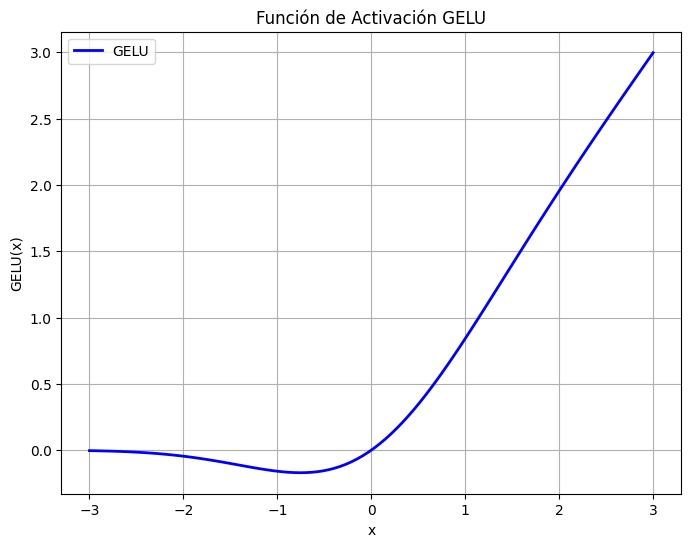

In [ ]:
#- Para $x>0$ : Similar a Relu, pero con una transición más suave y continua.
#- Para $x<0$ : A diferencia de ReLu , GELU no es cero, sino que se aproxima de manera suave a cero, permitiendo que los valores negativos también influyan en el entrenamiento.
import numpy as np
import matplotlib.pyplot as plt

# Definir la función GELU
def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))

# Crear un rango de valores para x
x = np.linspace(-3, 3, 100)

# Graficar
plt.figure(figsize=(8, 6))
plt.plot(x, gelu(x), label="GELU", color="b", linewidth=2)
plt.title("Función de Activación GELU")
plt.xlabel("x")
plt.ylabel("GELU(x)")
plt.grid(True)
plt.legend()
plt.show()


##**Función de pérdida**

In [ ]:
# Función de pérdida: incluye la ecuación diferencial y comparación con la solución analítica


def loss(t, N):
"""
La función loss(t, N) es una función de pérdida (también conocida como función de coste) que se utiliza para entrenar la red neuronal.
Esta función mide qué tan bien las predicciones de la red neuronal se ajustan a las soluciones correctas del problema de oscilador amortiguado,
considerando tanto la ecuación diferencial que describe el sistema como la solución analítica exacta.
"""


    t.requires_grad = True  # Permite calcular derivadas respecto a t
    """
    - Propósito: Establece que el tensor t necesita gradientes durante el cálculo.
    - ¿Por qué es necesario?: Para entrenar la red neuronal, necesitamos calcular las derivadas de las predicciones de la red con respecto al tiempo $t$, ya que estamos resolviendo una ecuación diferencial.
      Al hacer esto, indicamos que $t$ debe ser tratado como una variable "diferenciable" para poder calcular derivadas de las funciones que dependen de $t$.
    - requires_grad=True habilita la posibilidad de calcular el gradiente de t cuando realizamos las operaciones de autograd en PyTorch.
    """

    x = x_t(t, N)  # Solución aproximada
    """
    - Propósito: Calcula la solución aproximada de la red neuronal para un valor de tiempo t .
    - ¿Qué hace?: Llama a la función x_t , que toma el valor de tiempo t y la red neuronal N como entrada, y devuelve una predicción de la posición del oscilador en el tiempo t (es decir, la salida de la red neuronal).
    - Nota: La función x_t es una aproximación que la red neuronal está aprendiendo a predecir, con el objetivo de ajustarse a la solución correcta del problema de oscilador amortiguado.
    """

    dxdt = torch.autograd.grad(x, t, torch.ones_like(t), create_graph=True)[0]  # Primera derivada
    """
    - Propósito: Calcula la primera derivada de x respecto al tiempo t (es decir, la velocidad del oscilador).
    - ¿Qué hace?: Usa la función torch.autograd.grad para calcular el gradiente de x con respecto a t . Esto da como resultado la velocidad ( dx/dt ), que es la primera derivada de la posición del oscilador con respecto al tiempo.
    - Detalles:
- torch.ones_like(t) : Este argumento se usa para indicar que queremos calcular el gradiente de x con respecto a t considerando un valor de "1" como el gradiente de referencia.
- create_graph=True : Esto se establece para permitir que el cálculo del gradiente sea diferenciable a su vez. Esto es necesario porque, en la siguiente línea,
  también se calculará el gradiente de dxdt (segunda derivada), y necesitamos el grafo de cálculo para ese propósito.

    """

    d2xdt2 = torch.autograd.grad(dxdt, t, torch.ones_like(t), create_graph=True)[0]  # Segunda derivada
    """
    - Propósito: Calcula la segunda derivada de x respecto al tiempo t (es decir, la aceleración del oscilador).
    - ¿Qué hace?: Calcula la derivada de la velocidad ( dxdt ) con respecto al tiempo t usando torch.autograd.grad. Esto da la aceleración ( $\mathrm{d}^2 \mathrm{x} / \mathrm{dt}^2$ ), que es la segunda derivada de la posición con respecto al tiempo.
  - Detalles:
    - dxdt es la primera derivada que obtuvimos en el paso anterior, y estamos calculando su gradiente respecto a t para obtener la aceleración.
    - Al igual que en el paso anterior, usamos create_graph=True para poder calcular más derivadas en el futuro si fuera necesario.
    """

    """
    ***. [0]

    La función torch.autograd.grad devuelve una tupla de tensores. En este caso, aunque estemos calculando un único gradiente (la primera derivada de x con respecto a $t$ ),
    la función devuelve una tupla con un solo tensor, ya que el cálculo de gradientes siempre devuelve una tupla, incluso si hay solo un tensor.

    El [0] extrae el primer (y único) tensor de esa tupla, que es el gradiente de x con respecto a t , o la velocidad en el contexto del problema del oscilador. Entonces, [0] simplemente selecciona el tensor dentro de la tupla.
    """

    loss_ode = d2xdt2 + xi * dxdt + (w**2) * x  # Residuo de la ecuación diferencial


    error_analytical = torch.mean((x - x_sol_under(t))**2)  # Diferencia con la solución analítica
    return torch.mean(loss_ode**2) + 0.1 * error_analytical  # Combinación ponderada de ambas pérdidas


**Discusión de loss_ode**

`loss_ode = d2xdt2 + xi * dxdt + (w**2) * x ` # Residuo de la ecuación diferencial

- Propósito: Calcula el residuo de la ecuación diferencial del oscilador amortiguado.
- ¿Qué hace?: Esta línea implementa la ecuación diferencial que describe el movimiento del oscilador amortiguado:

$$
\frac{d^2 x}{d t^2}+\xi \cdot \frac{d x}{d t}+\omega^2 \cdot x=0
$$

- donde:

  - $\frac{d^2 x}{d t^2}$ es la aceleración (d2xdt2).
  - $\frac{d x}{d t}$ es la velocidad (dxdt ).
  - $\quad x$ es la posición del oscilador.
  - $\xi$ es el coeficiente de amortiguamiento.
  - $\omega^2$ es la frecuencia angular cuadrada.


- ¿Qué significa?: El residuo es la diferencia entre el lado izquierdo de la ecuación diferencial (lo que se calcula usando la derivada de x ) y el valor esperado, que debe ser cero si el modelo está siguiendo correctamente la ecuación. El residuo se debe minimizar para que el modelo ajuste bien la ecuación diferencial.




```
error_analytical = torch.mean((x - x_sol_under(t))**2)
```
- Propósito: Calcula el error entre la solución aproximada de la red neuronal y la solución analítica exacta.
- ¿Qué hace?: Compara la predicción de la red neuronal ( $x$ ) con la solución analítica exacta ( $x$ _sol_under(t) ) usando el error cuadrático medio (MSE).
- x_sol_under(t) es la solución exacta del oscilador amortiguado que has definido antes.
- torch.mean((x - x_sol_under(t) )**2) calcula la media del cuadrado de las diferencias entre la solución predicha por la red y la solución exacta.
- ¿Por qué es importante?: Este término mide cuán cerca está la red neuronal de la solución correcta en términos de la posición del oscilador.


`return torch.mean(loss_ode**2) + 0.1 * error_analytical`

- Propósito: Calcula la pérdida total (o coste) combinando los dos términos de error: el residuo de la ecuación diferencial y el error con respecto a la solución analítica.
- ¿Qué hace?:
- torch.mean(loss_ode**2) : La pérdida de la ecuación diferencial se calcula como el cuadrado del residuo loss_ode. Al elevarlo al cuadrado, se asegura de que los errores no negativos se sumen de manera efectiva.
- 0.1 * error_analytical : El error con respecto a la solución analítica se pondera con un factor de 0.1. Esto permite ajustar la importancia relativa entre ambos términos de la pérdida. El residuo de la ecuación diferencial tiene mayor peso en este caso, ya que el objetivo principal es que la red neuror resuelva correctamente la ecuación diferencial.

- ¿Qué significa el retorno?: La función devuelve la pérdida total como una combinación de ambas fuentes de error. Durante el entrenamiento, esta pérdida se minimizará para ajustar los pesos de la red neuronal y mejorar sus predicciones.

La función loss(t, N) calcula el error de la red neuronal en dos aspectos:
1. Residuo de la ecuación diferencial: Mide cuán bien el modelo satisface la ecuación diferencial que describe el movimiento del oscilador amortiguado.
2. Diferencia con la solución analítica: Mide cuán cerca están las predicciones del modelo de la solución exacta.

Estos dos errores se combinan en una pérdida total que se utiliza para ajustar los parámetros de la red neuronal mediante optimización.

##**OPtimizador**

In [ ]:
# Optimizador y scheduler para ajuste dinámico de la tasa de aprendizaje
optimizer = torch.optim.Adam(N.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.5)

- `torch.optim.Adam`:
- Adam (Adaptive Moment Estimation) es un optimizador que utiliza una combinación de dos técnicas de optimización:
1. Momentum: En lugar de utilizar solo la derivada en un punto, Adam también toma en cuenta los gradientes pasados, lo cual ayuda a suavizar las actualizaciones y hace que el proceso de optimización sea más estable.
2. Escalado adaptativo de la tasa de aprendizaje: Adam ajusta la tasa de aprendizaje de manera individual para cada parámetro, adaptándose a las características de los gradientes.

Adam es muy popular porque:
- Converge más rápido que otros métodos (como el gradiente descendente estándar).
- No requiere una tasa de aprendizaje fija, ya que ajusta la tasa automáticamente.
- Es especialmente eficiente para modelos grandes y problemas con muchos parámetros.

- `N. parameters()`:
  - N es la instancia de la red neuronal `OscillatorNN` (definida previamente).
  - El método `parameters()` devuelve todos los parámetros del modelo (pesos y sesgos de las capas de la red neuronal). Esos son los parámetros que el optimizador Adam ajustará durante el entrenamiento para minimizar la función de pérdida.

- `lr=0.01` :
 - Ir es la tasa de aprendizaje (learning rate), un hiperparámetro que controla la magnitud de los pasos que el optimizador da en cada iteración.
 - Aquí, se establece la tasa de aprendizaje inicial en 0.01. Esto significa que, en principio, el optimizador ajustará los parámetros en pasos de tamaño 0.01 durante cada actualización.


`scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.5)`

En esta línea se define un scheduler de tasa de aprendizaje, que es un mecanismo que ajusta dinámicamente la tasa de aprendizaje durante el entrenamiento. El scheduler ayuda a mejorar la convergencia del modelo reduciendo la tasa de aprendizaje cuando el progreso en la minimización de la función de pérdida se estanca.


- `torch.optim.lr_scheduler.ReduceLROnPlateau`:
 - Este tipo de scheduler reduce la tasa de aprendizaje cuando la función de pérdida deja de mejorar durante un número de iteraciones o épocas consecutivas. Es muy útil cuando el modelo se estanca en una región de la función de pérdida y no puede mejorar significativamente.
 - `ReduceLROnPlateau` se basa en el comportamiento de la pérdida: cuando no hay mejoras (la pérdida no mejora significativamente durante un número de épocas), el scheduler reduce la tasa de aprendizaje para que el modelo pueda hacer ajustes más finos.

 - `optimizer`:
  - El optimizaror que será ajustado dinámicamente por este scheduler. Es el optimizador Adam que definimos anteriormente.
- `patience=100`:
  - Este es un parámetro clave del scheduler, que define el número de épocas (o iteraciones) durante las cuales el modelo puede no mejorar en su rendimiento antes de que la tasa de aprendizaje sea reducida.
  - En este caso, el valor de `patience=100` significa que si la función de pérdida no mejora durante 100 épocas consecutivas, el scheduler reducirá la tasa de aprendizaje.

- `factor=0.5 `:
 - Este parámetro define por cuánto se reducirá la tasa de aprendizaje cuando la pérdida no haya mejorado durante el número de épocas indicado por patience.
 - En este caso, factor=0.5 significa que la tasa de aprendizaje se reducirá a la mitad cuando se active el scheduler. Por ejemplo, si la tasa de aprendizaje era de 0.01, después de reducirse, será de 0.005.

##**Entrenamiento**

In [ ]:
# Entrenamiento
t_train = torch.linspace(0, 2, 500).reshape(-1, 1)  # Puntos de entrenamiento
loss_history = []  # Para guardar la evolución de la pérdida

for epoch in range(5000):  # Hasta 5000 iteraciones
    optimizer.zero_grad()  # Reinicia gradientes
    l = loss(t_train, N)  # Calcula la pérdida
    l.backward()  # Calcula los gradientes
    optimizer.step()  # Actualiza los parámetros
    scheduler.step(l)  # Ajusta la tasa de aprendizaje
    loss_history.append(l.item())  # Guarda el valor de la pérdida
    if l.item() < 1e-5:  # Condición de parada
        break


```
t_train = torch.linspace(0, 2, 500).reshape(-1, 1)  # Puntos de entrenamiento

```
- torch.linspace(0, 2, 500):

  Esta función de PyTorch crea un tensor de 500 puntos igualmente distribuidos en el intervalo de 0 a 2. La secuencia resultante será algo como:
  [0, 0.004008, 0.008016, ..., 2].
  Es decir, genera valores de t (tiempo) para entrenar el modelo, distribuidos uniformemente entre 0 y 2.

- .reshape(-1, 1):
Este método cambia la forma (shape) del tensor resultante de la función linspace para que sea de una sola columna y múltiples filas.
 - El -1 indica que la dimensión correspondiente se ajustará automáticamente según la longitud del tensor (en este caso, 500 elementos).
 - El 1 indica que queremos que haya una sola columna, convirtiendo el tensor en una matriz de tamaño $(500,1)$.

En resumen, t_train es un tensor de 500 valores en el intervalo [0, 2], cada uno representando un punto de tiempo para el entrenamiento, con una forma de $(500,1)$.



```
loss_history = []
```
Esta línea inicializa una lista vacía llamada `loss_history`. Esta lista se usará para almacenar la evolución de la pérdida durante el entrenamiento, permitiendo luego graficarla y analizar cómo ha cambiado a medida que el modelo aprende.


**Bucle de entrenamiento:**

`for epoch in range(5000)`:
Este bucle `for` se ejecutará hasta 5000 épocas (iteraciones). Cada época representa una iteración completa a través de los datos de entrenamiento. En cada iteración, se realiza una actualización de los parámetros del modelo para que se ajuste mejor a la solución deseada (minimización de la función de pérdida).


`optimizer.zero_grad()`
- `optimizer.zero_grad() `:

Esta línea reinicia los gradientes acumulados de las iteraciones anteriores.
 - Los gradientes se calculan durante el proceso de retropropagación ( backward() ), y es importante reiniciarlos en cada época para evitar que se acumulen gradientes de épocas previas.
 - Si no se llamara a `zero_grad()`, los gradientes se acumularían, lo que afectaría negativamente a la actualización de los parámetros en cada paso.

`l = loss(t_train, N)`
- `loss(t_train, N)`:

Calcula el valor de la función de pérdida para los puntos de entrenamiento `t_train` y el modelo N .
 - El modelo N es una red neuronal definida previamente (la clase `OscillatorNN `), que se evalúa para estos puntos de tiempo `t_train`.
 - La función de pérdida mide qué tan lejos está la predicción de la red neuronal de la solución esperada (analítica), y en este caso incluye tanto la ecuación diferencial como la comparación con la solución analítica.
 - El valor de la pérdida `l` es un escalar que indica la calidad de la solución de la red neuronal para ese conjunto de puntos de tiempo.


`l.backward()`
- `1.backward()` :

Esta línea realiza la retropropagación para calcular los gradientes de la función de pérdida `l` con respecto a los parámetros de la red neuronal (pesos y sesgos).
- La retropropagación consiste en propagar el error de la función de pérdida hacia atrás a través de la red neuronal para calcular los gradientes, los cuales indican cómo deben actualizarse los parámetros del modelo.
- Estos gradientes se almacenan en los atributos de cada parámetro del modelo, para ser utilizados en la actualización de los pesos.


`optimizer.step()`
- `optimizer.step()`:

Esta línea actualiza los parámetros de la red neuronal.
- Usando los gradientes calculados durante la retropropagación, el optimizador (en este caso Adam) ajusta los pesos de la red para reducir la función de pérdida.
- El tamaño de la actualización está determinado por la tasa de aprendizaje ( `lr` ) definida anteriormente, y se ajusta de forma adaptativa por el optimizador.

`scheduler.step(l)`
- `scheduler.step(l)`:

Esta línea ajusta la tasa de aprendizaje usando el scheduler que fue definido antes.
 - El scheduler `ReduceLROnPlateau` ajusta la tasa de aprendizaje si detecta que la función de pérdida `l` no ha mejorado en las últimas épocas (según los parámetros patience y factor ).
 - Si el valor de la pérdida no mejora después de un número de épocas especificado (100 en este caso), la tasa de aprendizaje se reduce automáticamente, lo que permite hacer ajustes más finos al final del entrenamiento.



`loss_history.append(l.item())`
- `loss_history.append(l.item())`:

Esta línea agrega el valor de la pérdida (como un número escalar) a la lista loss_history .
 - `l.item()` convierte el tensor de la pérdida l en un número estándar de Python, lo que permite almacenarlo en la lista.
 - La lista `loss_history` contendrá todos los valores de la pérdida durante las épocas del entrenamiento, lo cual es útil para graficar y analizar cómo va evolucionando el aprendizaje.



`if l.item() < 1e-5`:
- `if l.item() < 1e-5`: :

Esta es una condición de parada que permite terminar el entrenamiento si la pérdida alcanza un valor suficientemente bajo.
 - 1e-5 es un valor muy pequeño, que indica que la red ha convergido a una solución bastante buena.
 - Si la pérdida es menor que este umbral, significa que el modelo ya ha aprendido lo suficiente, por lo que el entrenamient $\downarrow$, detiene antes de llegar a las 5000 épocas.


 `break`
- `break` :

Si la condición del if es verdadera (es decir, si la pérdida es menor que 1e-5), la ejecución del bucle de entrenamiento se detiene inmediatamente.
 - Esto es una medida para evitar entrenar innecesariamente por más épocas cuando el modelo ya ha alcanzado un buen rendimiento.


 - El código entrena la red neuronal para resolver el problema del oscilador amortiguado.
- En cada iteración:
1. Se reinician los gradientes.
2. Se calcula la pérdida (cómo de mal está el modelo).
3. Se realiza la retropropagación para obtener los gradientes.
4. Se actualizan los parámetros del modelo.
5. Se ajusta la tasa de aprendizaje si es necesario.
6. Se guarda el valor de la pérdida en una lista para monitorear el progreso.
- El proceso se detiene si el valor de la pérdida es suficientemente bajo (por debajo de 1e-5 ), lo que indica que el modelo ha aprendido bien.

# **Evaluación**

In [ ]:
# Evaluación
t_eval = torch.linspace(0, 2, 100).reshape(-1, 1)  # Puntos de evaluación
with torch.no_grad():
    nn_solution = x_t(t_eval, N).numpy()  # Solución de la red neuronal
analytical_solution = x_sol_under(t_eval).numpy()  # Solución analítica exacta

1. `t_eval = torch.linspace(0, 2, 100).reshape(-1, 1)`
- `torch.linspace(0, 2, 100)`:
  - Esta función genera un tensor con 100 valores igualmente espaciados en el intervalo de 0 a 2. Los puntos de tiempo `t_eval` se generan para evaluar el rendimiento del modelo en estos puntos.
  - El propósito de esta línea es crear un conjunto de puntos `t_eval` que cubren el rango de tiempo $[0,2]$ para el cual se desea verificar la solución de la red neuronal.

- `.reshape(-1, 1)`:
 - Al igual que en el bloque de entrenamiento, este método cambia la forma del tensor generado para convertirlo en un tensor columna de tamaño (100, 1), es decir, con 100 filas y 1 columna.
 - Este paso es necesario para asegurar que el modelo reciba la entrada con la forma adecuada (en este caso, de una sola dimensión para cada punto de tiempo).

 2. `with torch.no_grad()`:
- `torch.no_grad()`:
 - Este es un contexto que desactiva el seguimiento de los gradientes, lo que significa que no se calcularán los gradientes de los tensores durante las operaciones dentro de este contexto.
 - Esto es importante durante la evaluación porque no necesitamos calcular gradientes (que son necesarios solo para el entrenamiento), lo que hace el proceso más eficiente y rápido.
 - Al utilizar `torch.no_grad()` , PyTorch evita almacenar la información necesaria para realizar la retropropagación, reduciendo el uso de memoria y acelerando el cómputo.

 3. `nn_solution = x_t(t_eval, N).numpy()`
 - `x_t(t_eval, N)`:
 - `x_t` es la función lambda que define la solución aproximada de la red neuronal para un conjunto de puntos de tiempo t_eval . Se calcula utilizando el modelo entrenado N .
 - Aquí, `x_t(t_eval, N)` calcula las salidas de la red neuronal `N` para los valores de tiempo t_eval , lo cual da la solución aproximada de la red neuronal para esos puntos de tiempo.

- `.numpy()`:
 - Este método convierte el tensor de PyTorch resultante de `x_t(t_eval, N )` en un arreglo de Numpy.
 - Esto es útil porque Matplotlib y otras herramientas de análisis en Python trabajan de forma más eficiente con arreglos de Numpy en lugar de tensores de PyTorch, por lo que esta conversión es esencial para realizar las gráficas y análisis posteriores.

 4. `analytical_solution = x_sol_under(t_eval).numpy()`
- `X_sol_under(t_eval)`:
 - `x_sol_under` es la función lambda que representa la solución analítica exacta para el oscilador amortiguado, calculada a partir de la fórmula física que modela el comportamiento del sistema.
 - Esta línea evalúa la solución analítica para los mismos puntos de tiempo `t_eval` generados en la primera línea.
 - Al evaluar `x_sol_under(t_eval)` , obtenemos un tensor con los valores de la posición en el tiempo, según la solución exacta del oscilador amortiguado.
- `.numpy()`:
- Similar a la línea anterior, esta llamada convierte el tensor de la solución analítica en un arreglo de Numpy para poder utilizarlo en análisis y visualización posteriores.


Resumen:

Este bloque de código realiza la evaluación del modelo entrenado al calcular y comparar las soluciones aproximadas y exactas en un conjunto de puntos de tiempo:
1. Se crean 100 puntos de tiempo entre 0 y 2 para evaluar la red neuronal.
2. Dentro del contexto de torch.no_grad( ) , se calculan las predicciones de la red neuronal usando esos puntos de tiempo y se almacenan en nn_solution.
3. También se calcula la solución analítica exacta para esos mismos puntos de tiempo y se almacena en analytical_solution.

##**Sección de gráfica de resultados**

In [ ]:
# Gráficas
# 1. Solución analítica vs red neuronal
plt.figure(dpi=300) # Esta función crea una nueva figura en Matplotlib, que es donde se van a dibujar los gráficos.
plt.plot(t_eval, analytical_solution, label="Solución Analítica", linewidth=3, alpha=0.7)
plt.plot(t_eval, nn_solution, "--", label="Red Neuronal", color="k")
plt.xlabel("Tiempo")
plt.ylabel("Posición x(t)")
plt.title("Comparación de Soluciones")
plt.legend()
plt.show()


- `plt.plot(t_eval, analytical_solution, label="Solución Analítica", linewidth=3, alpha=0.7) `:
 - `t_eval `: Este es el conjunto de puntos de tiempo (en el intervalo de 0 a 2) que hemos generado previamente para la evaluación.
 - `analytical_solution` : Son los valores de la solución analítica para los puntos de tiempo correspondientes a t_eval .
 - `label="Solución Analítica" `: Establece la etiqueta para la leyenda del gráfico, que en este caso es "Solución Analítica". Esta etiqueta aparece en el gráfico para indicar qué línea corresponde a la solución exacta.
 - `linewidth=3` : Ajusta el ancho de la línea de la gráfica a 3. Esto hace que la línea sea más gruesa y más visible en el gráfico.
 - `alpha=0.7`: Ajusta la transparencia de la línea. El valor alpha=0.7 significa que la línea tendrá un $30 \%$ de transparencia, lo que hace que sea ligeramente más suave.



- `plt.plot(t_eval, nn_solution, "--", label="Red Neuronal", color="k")`:
 - `t_eval` : Los mismos puntos de tiempo de antes, en el intervalo de 0 a 2.
 - `nn_solution` : Los valores calculados por la red neuronal para los mismos puntos de tiempo `t_eval`.
 - `"--" `: Establece el estilo de la línea como una línea discontinua (línea punteada). Esto ayuda a distinguir visualmente entre las dos soluciones (analítica y de la red neuronal).
 - `label="Red Neuronal" `: Define la etiqueta para esta línea en la leyenda, que será "Red Neuronal".
  - `color="k" `: Define el color de la línea como "k", que es una abreviatura en Matplotlib para negro. Esto hace que la línea de la red neuronal sea de color negro.

- `plt.xlabel("Tiempo")`
 - Esta línea establece la etiqueta del eje $\mathbf{x}$, que en este caso es "Tiempo". Esto es importante para que el gráfico tenga etiquetas claras y sea fácilmente interpretable.

- `plt.ylabel("Posición x(t)")`:
 - Aquí se define la etiqueta del eje $y$, que será "Posición $x(t)$ ", indicando que el gráfico muestra cómo cambia la posición del oscilador con el tiempo.

- `plt.title("Comparación de Soluciones")`:
 - Establece el título del gráfico, que en este caso es "Comparación de Soluciones". Esto da un contexto al gráfico y ayuda a entender rápidamente qué se está comparando.

- `plt.legend()`:
- Esta función agrega una leyenda al gráfico. La leyenda utilizará las etiquetas definidas previamente en label="Solución Analítica" y label="Red Neuronal" para identificar las dos líneas que se dibujaron.
- La leyenda ayuda a que el lector identifique cuál es la solución analítica y cuál es la salida de la red neuronal en el gráfico.